In [1]:
import os
import wandb
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

import lightning as L
from lightning.pytorch.cli import LightningCLI


import matplotlib.pyplot as plt
import matplotlib.animation as animation
import plotly.express as px
from tqdm import tqdm
from scipy import ndimage

import sys
sys.path.append('../')

#Models
from models.swin_fir.swin_fir import SwinFIR, SwinFIR_sidechannel
from models.interpolation_models import InterpolationModel
from models.edsr_sr.edsr import EDSR, EDSR_sidechannel

#Data
from dataset_utils.ERA2CERRA import ERA2CERRA_Dataset
from dataset_utils.ERA_dataset import ERA_Dataset
from dataset_utils.LightningDataModules import Era2CerraDataModule, EraDataModule



In [2]:
device = torch.device('cpu')

model = SwinFIR_sidechannel.load_from_checkpoint("../artifacts/wj8yuabe:v8/model.ckpt", map_location=device).eval()
model_size = sum(p.numel() for p in model.parameters())
print(f"Model size: {model_size} parameters")


Dataset metrics provided. Using provided values.
Model size: 16497302 parameters


/opt/homebrew/anaconda3/envs/climate/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [3]:
datamodule = Era2CerraDataModule("../data", downscaling_factor=model.hparams.upscale, num_workers=0, batch_size=10, crop_size=model.hparams.img_size * model.hparams.upscale, channel_names=model.hparams.channel_names, constant_channels = True, return_era_original=True, return_offset=True, test_years=[2020,2020], use_separate_dataset=True)
datamodule.setup('test')
dataloader = datamodule.test_dataloader()
dataset = dataloader.dataset

channel_names = model.hparams.channel_names

Loading Era2Cerra DataModule 

Loaded Mean/Std from file
Using ERA5 and CERRA dataset with separate u10/v10
Return dataset in custom mode. Years [2020]
Number of Files 1
Loaded Mean/Std from file
Dataset running in deterministic cropping mode. Number of crops per sample: 16. Total length: 3840
Loaded constant data from file


### Helper Functions

In [4]:
def upsample(input, downscaling_factor=4):
    # Upsample the output to the size of the input
    upsampled_output = F.interpolate(input.unsqueeze(0), scale_factor=downscaling_factor, mode='bicubic', align_corners=False)
    return upsampled_output


def predict(data):
    model.eval()

    era_original = None

   
    lr = data[0][0]
    hr = data[1][0]
    const_data = data[1][1]

    with torch.no_grad():
        input = lr.to(device)
        input_const = const_data.to(device)

        output = model((input.unsqueeze(0), input_const.unsqueeze(0)))
        output = output[0]


    input = input.cpu()
    output = output.cpu()  

    upsample_output = upsample(lr, model.hparams.upscale)


    # hr = hr.unsqueeze(0)
    input = input * dataset.variable_std + dataset.variable_mean
    hr = hr.unsqueeze(0) * dataset.variable_std + dataset.variable_mean
    output = output * dataset.variable_std + dataset.variable_mean
    upsample_output = upsample_output * dataset.variable_std + dataset.variable_mean

    if era_original is not None:
        era_original = era_original * dataset.variable_std + dataset.variable_mean

    return [input, output, upsample_output, hr, era_original]

Inputs: torch.Size([10, 20, 64, 64]), Outputs: torch.Size([10, 20, 256, 256]), Cerras: torch.Size([10, 20, 256, 256])


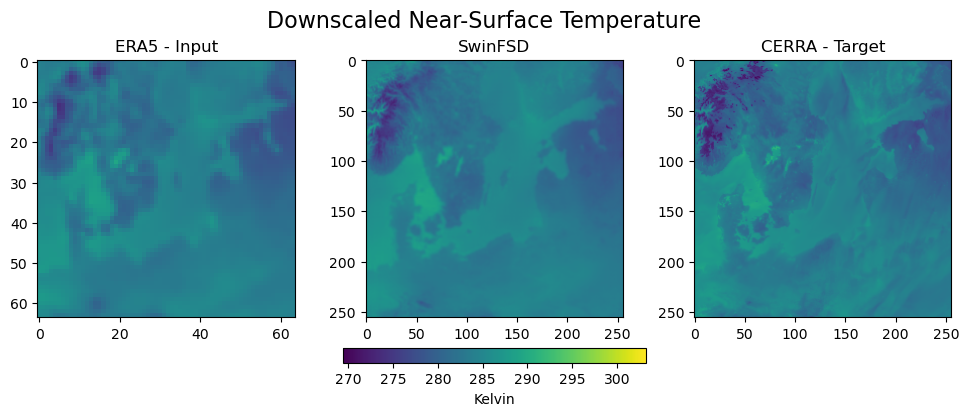

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

prediction_steps = 10
location = 6

inputs = []
outputs = []
cerras = []

for i in range(prediction_steps):
    idx = i * 16 + location
    data = dataset[idx]
    input, output, upsample_output, hr, era_original = predict(data)

    inputs.append(input)
    outputs.append(output.squeeze())
    cerras.append(hr.squeeze())


inputs = torch.stack(inputs)
outputs = torch.stack(outputs)
cerras = torch.stack(cerras)

print(f"Inputs: {inputs.shape}, Outputs: {outputs.shape}, Cerras: {cerras.shape}")

vmin = min(inputs[:, 2].min(), outputs[:, 2].min(), cerras[:, 2].min())
vmax = max(inputs[:, 2].max(), outputs[:, 2].max(), cerras[:, 2].max())


fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("Downscaled Near-Surface Temperature", fontsize=16)
fig.tight_layout()
ax[0].set_title("ERA5 - Input", fontsize=12)
ax[1].set_title("SwinFSD", fontsize=12)
ax[2].set_title("CERRA - Target", fontsize=12)
im2 = ax[0].imshow(inputs[0, 2].cpu().numpy(), vmin=vmin, vmax=vmax, animated=True)
im3 = ax[1].imshow(outputs[0, 2].cpu().numpy(), vmin=vmin, vmax=vmax, animated=True)
im1 = ax[2].imshow(cerras[0, 2].cpu().numpy(), vmin=vmin, vmax=vmax, animated=True)
cbar = fig.colorbar(im3, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label("Kelvin")

def update(i):
    im1.set_array(cerras[i, 2].cpu().numpy())
    im2.set_array(inputs[i, 2].cpu().numpy())
    im3.set_array(outputs[i, 2].cpu().numpy())
    return im1, im2, im3


ani = animation.FuncAnimation(fig, update, frames=inputs.shape[0], interval=10, blit=True)
#ani.save('animation.gif', fps=10)
plt.show()